In [21]:
# (1) Read data

import pandas as pd
import numpy as np

row_data = pd.read_csv("datasetRootform.csv")
row_data['msg'].replace('', np.nan, inplace=True)
row_data.dropna(subset=['msg'], inplace=True)
row_data.describe()

role                                                msg    tag
count      49240                                              49240  49240
unique         7                                              44702  40606
top     Employee  warn sent automatically inform mailbox approac...   n n 
freq       18413                                                178    225

In [22]:
# (2) Clean data
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
import numbers

# remove null rows
null_removed_df = row_data[row_data['msg'].astype(bool)]
null_removed_df = row_data[row_data['role'].astype(bool)]
null_removed_df

# Remove punctuations
dataset = null_removed_df['msg'].tolist()
for i in range(len(dataset)):
    dataset[i] = '' if isinstance(dataset[i], float) else dataset[i]
    dataset[i] = dataset[i].lower() 
    dataset[i] = re.sub(r'\W', ' ', dataset[i]) 
    dataset[i] = re.sub(r'\s+', ' ', dataset[i])

# remove stop words
stop_words = set(stopwords.words('english'))

word_text = []
for data in dataset: 
    line = []
    words = nltk.word_tokenize(data)
    for w in words:
        if w not in stop_words: 
            line.append(w)
    word_text.append(line)
DATASET_SIZE = len(word_text)

# convert to root form
# def get_wordnet_pos(word):
#     """Map POS tag to first character lemmatize() accepts"""
#     tag = nltk.pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": wordnet.ADJ,
#                 "N": wordnet.NOUN,
#                 "V": wordnet.VERB,
#                 "R": wordnet.ADV}

#     return tag_dict.get(tag, wordnet.NOUN)

# lemmatizer = WordNetLemmatizer()

text_root_form = word_text
# text_root_form = []
# for line in word_text:
#     root_line = []
#     for word in line:
#         root_line.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))
#     text_root_form.append(root_line)
# len(text_root_form)

[nltk_data] Downloading package punkt to /home/chaminda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/chaminda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chaminda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/chaminda/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [23]:
# (3) Read role from file

In [24]:
# (4) Bind roles to dataset

In [25]:
# (5) Select role, content, sender

In [26]:
# (6) Content vectorized by GloVe
# Get glove data
import os
embeddings_index={}
NUM_OF_DIMS = 25
f=open(os.path.join('','glove.twitter.27B.25d.txt'),encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.array(values[1:]).astype(np.float)
    embeddings_index[word]=coefs
f.close

# Vectorize words
text_vec = []
for line in text_root_form:
    line_vec = []
    for word in line:
        if word in embeddings_index.keys():
            line_vec.append(embeddings_index[word])
    text_vec.append(line_vec)
len(text_vec)

49240

In [44]:
labels = null_removed_df['role'].tolist()

index_list =[]
for index,line in enumerate(text_vec):
    if len(line) == 0:
        index_list.append(index)
        
index_list.reverse()
for index in index_list:
    labels.pop(index)
    text_vec.pop(index)

DATASET_SIZE = len(text_vec)

In [45]:
# (7) Centroid for each text
text_centroid = []
for line in text_vec:
    line_centroid = np.zeros(25)
    for vec in line:
        for index,val in enumerate(vec):
            line_centroid[index] += val
    word_count = len(line)
    text_centroid.append(list(map(lambda x: x/word_count, line_centroid)))
len(text_centroid)

49165

In [46]:
# (8) Role and senders one hot encoding
from keras.utils import to_categorical

lbl_int = {'CEO': 0,
 'Director': 1,
 'Employee': 2,
 'Manager': 3,
 'President': 4,
 'Trader': 5,
 'Vice President': 6}
#lbl_int = {'business':0, 'entertainment':1, 'politics':2, 'sport':3, 'tech':4}
# labels = null_removed_df['role'].tolist()

labelsInt = list()
for txt in labels:
    labelsInt.append(lbl_int[txt])

encodeLabels = to_categorical(np.asarray(labelsInt))
len(encodeLabels)

49240

In [47]:
# (9) Bind role, Sender, msg_vec, and centroid vec
import math

dataset_in_tuples = []
for index in range(0, DATASET_SIZE):
    #(role,msg_vec,centroid,sender)
    line_tuple = (encodeLabels[index],text_vec[index],text_centroid[index])
    dataset_in_tuples.append(line_tuple)
print("dataset_in_tuples: ",len(dataset_in_tuples))

# Split training and testing data
TRAINING_RATIO = 0.7
train_count = math.floor(TRAINING_RATIO * DATASET_SIZE)
train_in_tuples = []
for index in range(0,train_count):
    train_in_tuples.append(dataset_in_tuples[index])    
    
test_in_tuples = []    
for index in range(train_count, DATASET_SIZE):
    test_in_tuples.append(dataset_in_tuples[index])
    
print("train_in_tuples: ",len(train_in_tuples))
print("test_in_tuples: ",len(test_in_tuples))

dataset_in_tuples:  49165
train_in_tuples:  34415
test_in_tuples:  14750


In [48]:
# (10) Find centroid for each class
#### Only for training data ####
TRAIN_SIZE = len(train_in_tuples)
train_labels_int = labelsInt[:train_count]

class_centroids = np.zeros((len(lbl_int),NUM_OF_DIMS))
class_count = np.zeros(len(lbl_int))

for index in range(0,TRAIN_SIZE):
    cls_num = train_labels_int[index]
    class_count[cls_num] += 1
    for d in range(0, NUM_OF_DIMS):
        class_centroids[cls_num][d] += train_in_tuples[index][2][d]

for index in range(0,len(lbl_int)):
    for d in range(0, NUM_OF_DIMS):
        class_centroids[index][d] /= class_count[index]
class_centroids

array([[-8.15705093e-02,  3.98027901e-01, -1.61740121e-01,
        -2.13182109e-01, -1.41779231e-02, -2.97402964e-01,
         4.68181137e-01, -2.92644618e-01,  2.40006124e-01,
        -2.33242492e-01, -7.15372704e-02,  2.02759157e-01,
        -3.10531276e+00,  5.30930228e-02,  3.14267472e-01,
         2.24569401e-02,  2.62703489e-01, -2.13779862e-01,
        -8.79553517e-02, -1.70848172e-01, -1.63867583e-01,
        -2.07495539e-01, -1.40286255e-01, -1.81276115e-02,
        -4.79828349e-01],
       [-7.26164985e-02,  3.98154713e-01, -1.60165374e-01,
        -2.11088126e-01, -6.89410915e-04, -2.99864376e-01,
         4.73026904e-01, -2.99185108e-01,  2.52187759e-01,
        -2.21164020e-01, -6.20405122e-02,  2.03562823e-01,
        -3.11019846e+00,  5.27817664e-02,  3.07027195e-01,
         2.47967887e-02,  2.63828552e-01, -2.11375329e-01,
        -8.84753736e-02, -1.79158593e-01, -1.76816475e-01,
        -2.16761753e-01, -1.27224178e-01, -1.29141386e-02,
        -4.80490950e-01],
    

In [49]:
# (11) Select N words nearest to perticular class centroid
from heapq import nsmallest 
N = 40

N_words_contents_index = []
for index in range(0,TRAIN_SIZE):
    word_distances = {}
    word_count = len(train_in_tuples[index][1])
    for word_index,word in enumerate(train_in_tuples[index][1]):
        word_distances[word_index] = np.linalg.norm(word-class_centroids[train_labels_int[index]])
    N_words_contents_index.append(nsmallest(min(N,word_count), word_distances, key = word_distances.get))
len(N_words_contents_index)

34415

In [50]:
# (12) Average 25d vector for each content
Train_ds = []
Train_lbl = []
for line_index,line in enumerate(train_in_tuples):
    line_avg = np.zeros(NUM_OF_DIMS)
    for word_index,vec in enumerate(line[1]):
        if word_index in N_words_contents_index[line_index]:
            for index,val in enumerate(vec):
                line_avg[index] += val
    word_count = len(N_words_contents_index[line_index])
    Train_ds.append(list(map(lambda x: x/word_count, line_avg)))
    Train_lbl.append(line[0])
print("Train: ",len(Train_ds))

Test_ds = []
Test_lbl = []
for line in test_in_tuples:
    line_avg = np.zeros(NUM_OF_DIMS)
    for vec in line[1]:
        for index,val in enumerate(vec):
            line_avg[index] += val
    word_count = len(line[1])
    Test_ds.append(list(map(lambda x: x/word_count, line_avg)))
    Test_lbl.append(line[0])
print("Test: ",len(Test_ds))

Train:  34415
Test:  14750


In [51]:
# Datasets to numpy arrays 

Train_data = np.asarray(Train_ds)
Test_data = np.asarray(Test_ds)
Train_lbl = np.asarray(Train_lbl)
Test_lbl = np.asarray(Test_lbl)

In [61]:
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers

# create a model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(25, activation='tanh'))
# Add another:
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(20, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(7, activation='softmax'))

In [62]:
# from keras import backend as K
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_score(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

# METRICS = [ 
#       keras.metrics.CategoricalAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
#       f1_score
# ]
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]



# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=METRICS)
# model.summary();
#CategoricalCrossentropy

In [63]:
# train model
history = model.fit(Train_data, Train_lbl, epochs=40, validation_data=(Test_data, Test_lbl))

# , callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')]

Epoch 1/40
1076/1076 [==============================] - 3s 3ms/step - loss: 0.1076 - tp: 355.0000 - fp: 489.0000 - tn: 206001.0000 - fn: 34060.0000 - accuracy: 0.8566 - precision: 0.4206 - recall: 0.0103 - auc: 0.7508 - val_loss: 0.1193 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 88500.0000 - val_fn: 14750.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6558
Epoch 2/40
1076/1076 [==============================] - 2s 2ms/step - loss: 0.1072 - tp: 7.0000 - fp: 5.0000 - tn: 206485.0000 - fn: 34408.0000 - accuracy: 0.8571 - precision: 0.5833 - recall: 2.0340e-04 - auc: 0.7527 - val_loss: 0.1199 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 88499.0000 - val_fn: 14750.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6548
Epoch 3/40
1076/1076 [==============================] - 2s 2ms/step - loss: 0.1071 - tp: 0.0000e+00 - fp: 5.0000 - tn: 206485.0000 - fn: 34415.0000 - accuracy: 0.8571 - preci

Epoch 21/40
1076/1076 [==============================] - 3s 3ms/step - loss: 0.1071 - tp: 2.0000 - fp: 1.0000 - tn: 206489.0000 - fn: 34413.0000 - accuracy: 0.8571 - precision: 0.6667 - recall: 5.8114e-05 - auc: 0.7532 - val_loss: 0.1188 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 88500.0000 - val_fn: 14750.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6596
Epoch 22/40
1076/1076 [==============================] - 3s 3ms/step - loss: 0.1071 - tp: 2.0000 - fp: 0.0000e+00 - tn: 206490.0000 - fn: 34413.0000 - accuracy: 0.8571 - precision: 1.0000 - recall: 5.8114e-05 - auc: 0.7525 - val_loss: 0.1198 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 88500.0000 - val_fn: 14750.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6550
Epoch 23/40
1076/1076 [==============================] - 3s 2ms/step - loss: 0.1071 - tp: 2.0000 - fp: 0.0000e+00 - tn: 206490.0000 - fn: 34413.0000 - accuracy: 0.8

1076/1076 [==============================] - 2s 2ms/step - loss: 0.1071 - tp: 2.0000 - fp: 0.0000e+00 - tn: 206490.0000 - fn: 34413.0000 - accuracy: 0.8571 - precision: 1.0000 - recall: 5.8114e-05 - auc: 0.7530 - val_loss: 0.1198 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 88500.0000 - val_fn: 14750.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6596


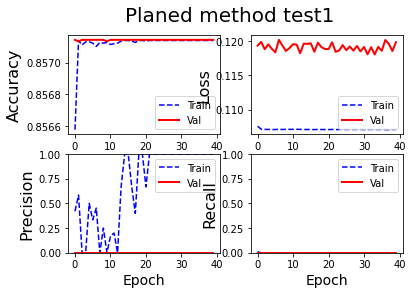

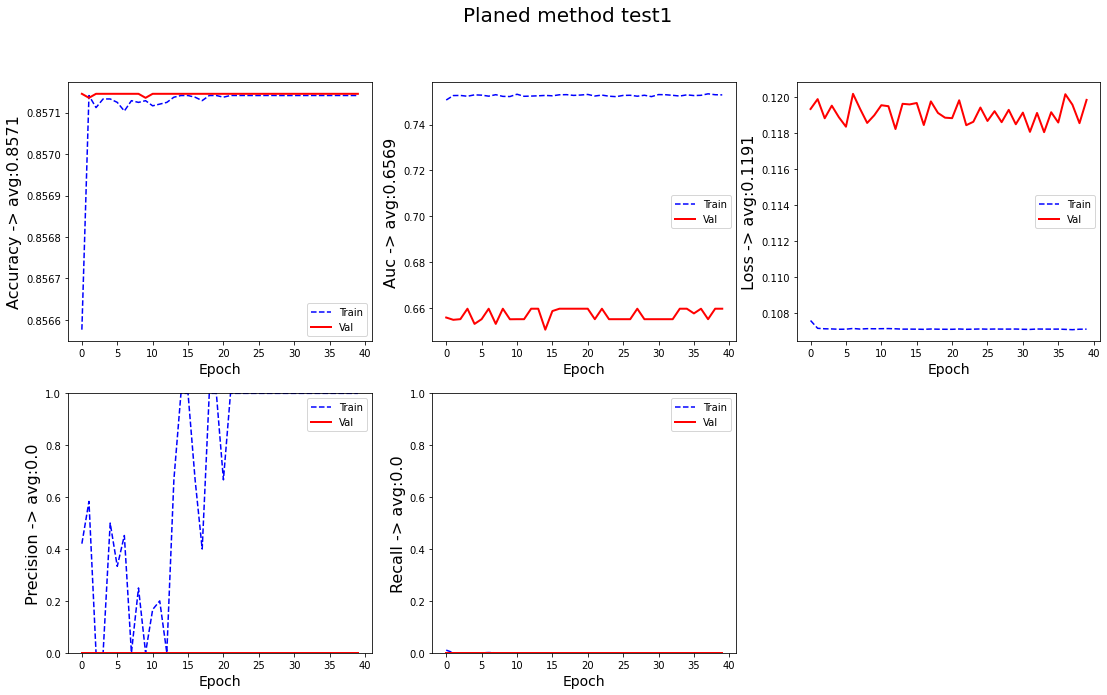

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

figName = "Planed method test1"

metrics =  ['accuracy', 'loss', 'precision', 'recall']
fig = plt.figure()
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], 'b', linestyle="--", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], 'r', label='Val',linewidth=2.0)
    plt.xlabel('Epoch',fontsize = 14)
    plt.ylabel(name, fontsize = 16)
    if metric == 'precision' or metric == 'recall':
      plt.ylim([0.0,1])
    else:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()
fig.suptitle(figName,fontsize=20)
fig.savefig(figName+'.png')


metrics =  ['accuracy','auc', 'loss', 'precision', 'recall']
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch,  history.history[metric], 'b', linestyle="--", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], 'r', label='Val',linewidth=2.0)
    plt.xlabel('Epoch',fontsize = 14)
    avg = sum(history.history['val_'+metric])/len(history.history[metric])
    plt.ylabel(name+" -> avg:"+str(round(avg,4)), fontsize = 16)
    if metric == 'precision' or metric == 'recall':
      plt.ylim([0.0,1])
    else:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()
fig.suptitle(figName,fontsize=20)
fig.savefig(figName+'.png')